In [1]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def modulo_degrees_between_m180_p180(angle_degrees):
    '''
    Inputs:
        angle_degrees: np.array

    Convert arbitrary angle in degrees (any real number) to that between -180
    and +180 degrees.
    '''
    angle_new = angle_degrees % 360.0
    angle_new[angle_new > 180.0] -= 360.0

    return angle_new


In [3]:
def is_between_lo_hi(x, lo, hi):
    '''
    Inputs:
        x: float or nd np.array
        lo: float, lower bound
        hi: float, upper bound
    Returns:
        out: bool nd np.array of same shape as x indicating whether each element is
             between lo and hi
    '''
    out = (x >= lo) * (x < hi)
    return out


In [4]:
def find_contiguous_trues(x):
    '''
    Input:
        x: bool 1d np.array

    Identifies the start locations and lengths of all contiguous chunks of
    True values, separated by one or more False values.
    '''
    starts = []
    lengths = []
    acc_len = 0

    if len(x) == 0:
        return []

    if x[0] == True:
        starts.append(0)
        acc_len += 1

    for i in range(1,len(x)):
        if x[i] == True:
            acc_len += 1
            if x[i-1] == False:
                starts.append(i)
        else:
            if acc_len > 0:
                lengths.append(acc_len)
            acc_len = 0

    # If last value was True, add acc_len to lengths
    if acc_len > 0:
        lengths.append(acc_len)

    assert len(starts) == len(lengths)

    out = list(zip(starts, lengths))

    return out



In [219]:
def analyze_fix_stationary(hdf_path, front_region=[-15,15]):
    #h5f_path = "/Users/yandanwang/Desktop/fix_stationary/20220410_201217.h5"

    ## Import data from h5 file
    h5f = h5py.File(hdf_path, 'r')

    trials = h5f['trials']
    iti = h5f.attrs['iti'] if 'iti' in h5f.attrs.keys() else 2 # if iti was not saved, assume 2 seconds
    stim_duration = h5f.attrs['fix_duration']

    ## for each trial, get...
    acc_fixation_success = []
    acc_fixation_durations = []
    acc_max_fixation_duration = []
    for tkey in trials.keys():
        #tkey='000'
        trial = trials[tkey]

        ### 0. Pull out timestamps and theta from trial object
        theta_rad = trial['ft_theta'][()] # raw theta in radians from Fictrac
        theta_rad -= theta_rad[0] # theta in radians relative to the beginning of trial
        theta_deg = np.rad2deg(theta_rad)
        ts = trial['ft_timestamps'] # timestamps in seconds since epoch
        ts -= (ts[0] + iti) # timestamps in seconds relative to the first timestamp of trial
        dt = np.mean(np.diff(ts)) # average width of a time step

        theta_bar_0 = trial.attrs['start_theta'] #degrees
        theta_bar = theta_bar_0 - theta_deg # bar position
        
        stim_period_mask = is_between_lo_hi(ts, 0, stim_duration)
        ts_stim = ts[stim_period_mask]
        theta_deg_stim = theta_deg[stim_period_mask]
        theta_bar_stim = theta_bar[stim_period_mask]

        ### 1. amount of time spent in the front region (param)
        theta_wrapped = modulo_degrees_between_m180_p180(theta_bar_stim)
        in_front_region = is_between_lo_hi(theta_wrapped, \
                                           lo=front_region[0], hi=front_region[1])
        duration_in_front_region = np.sum(in_front_region) * dt # in seconds
        proportion_in_front_region = np.sum(in_front_region) / len(in_front_region)

        print(f'Trial {tkey}: {duration_in_front_region:.2f}s ({proportion_in_front_region * 100:.1f}%) in front')

        ### 2. Quantify successful fixation (defined as >2s of staying within front region)
        true_chunks = find_contiguous_trues(in_front_region)
        fixation_durations = np.asarray([x[1]*dt for x in true_chunks])

        fixation_success = np.any(fixation_durations >= 2)
        if np.sum(fixation_durations) == 0:
            max_fixation_duration = 0
        else:
            max_fixation_duration = np.max(fixation_durations)
        #max_fixation_duration = np.max(fixation_durations)
        acc_fixation_success.append(fixation_success)
        acc_fixation_durations.append(fixation_durations)
        acc_max_fixation_duration.append(max_fixation_duration)

        print(f'Trial {tkey}: Fixation success: {fixation_success}')
        print(f'Trial {tkey}: Maximum fixation duration: {max_fixation_duration:.2f}s')
        
        #plt.figure()
        #plt.plot(ts, modulo_degrees_between_m180_p180(theta_bar))
        fig,ax = plt.subplots(2,1, figsize=(10,6))
        ax[0].plot(ts, np.sin(np.deg2rad(theta_bar)))
        ax[0].set_ylim([-1,1])
        ax[0].set_ylabel(r"sin($\theta_{bar}$)")
        ax[0].grid(True)
        ax[1].plot(ts, modulo_degrees_between_m180_p180(theta_bar))
        ax[1].set_ylim([-180,180])
        ax[1].set_ylabel(r"$\theta_{bar}$ [$\circ$]")
        ax[1].set_xlabel('Time [s]')        
        ax[1].grid(True)
        plt.show()
        
    h5f.close()
    
    return acc_fixation_success, acc_fixation_durations,acc_max_fixation_duration


Trial 000: 13.72s (45.7%) in front
Trial 000: Fixation success: True
Trial 000: Maximum fixation duration: 4.75s


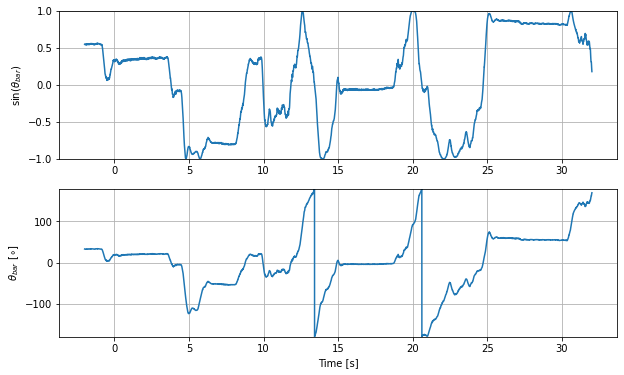

Trial 001: 9.68s (32.3%) in front
Trial 001: Fixation success: True
Trial 001: Maximum fixation duration: 5.59s


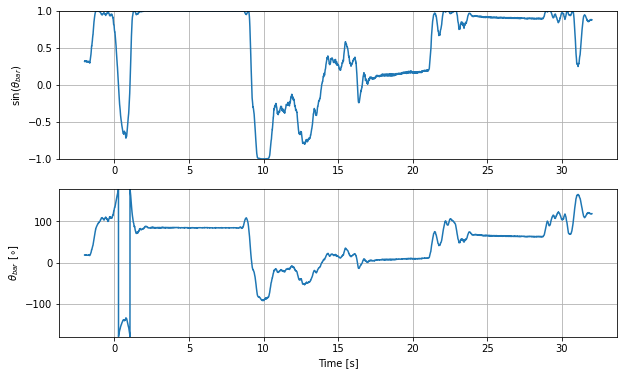

Trial 002: 6.09s (20.3%) in front
Trial 002: Fixation success: True
Trial 002: Maximum fixation duration: 4.86s


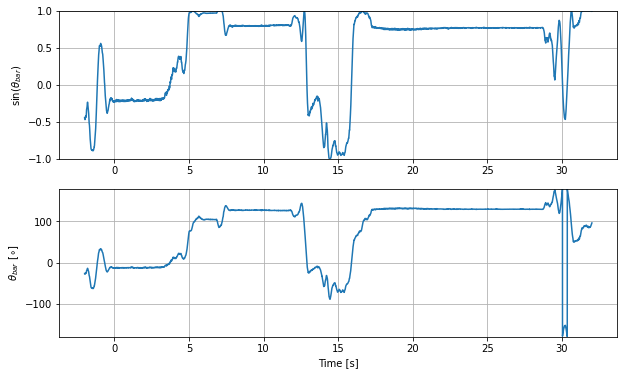

Trial 003: 1.98s (6.6%) in front
Trial 003: Fixation success: False
Trial 003: Maximum fixation duration: 1.23s


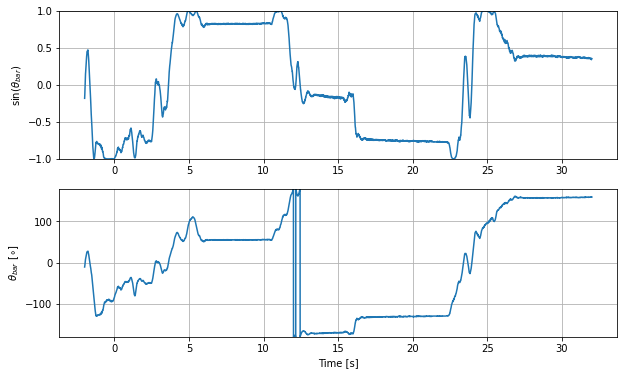

Trial 004: 8.43s (28.1%) in front
Trial 004: Fixation success: True
Trial 004: Maximum fixation duration: 5.83s


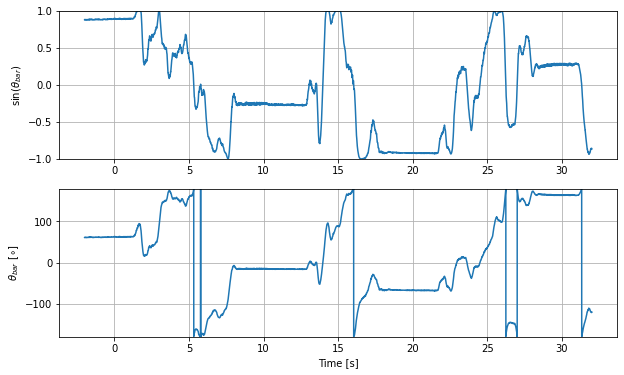

Trial 005: 3.75s (12.5%) in front
Trial 005: Fixation success: False
Trial 005: Maximum fixation duration: 0.78s


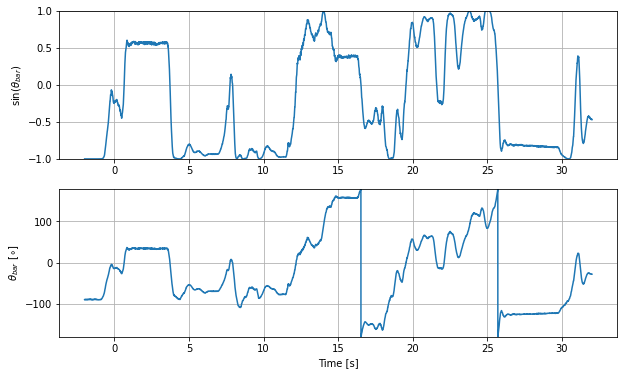

Trial 006: 4.35s (14.5%) in front
Trial 006: Fixation success: True
Trial 006: Maximum fixation duration: 2.50s


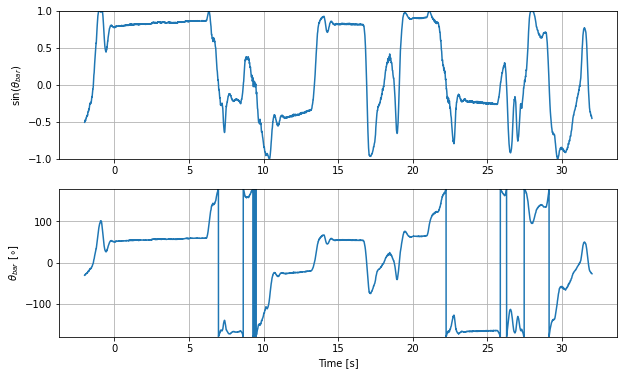

Trial 007: 3.55s (11.8%) in front
Trial 007: Fixation success: False
Trial 007: Maximum fixation duration: 0.88s


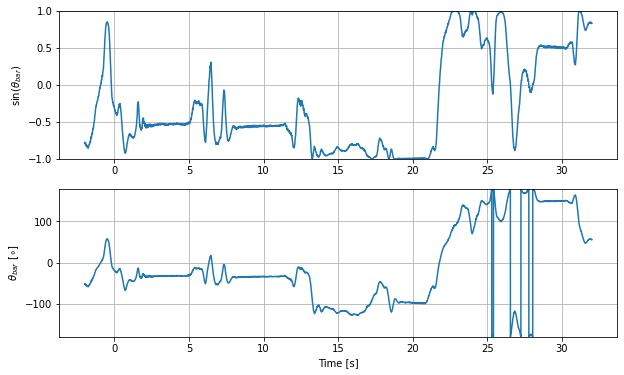

Trial 008: 2.35s (7.8%) in front
Trial 008: Fixation success: False
Trial 008: Maximum fixation duration: 0.98s


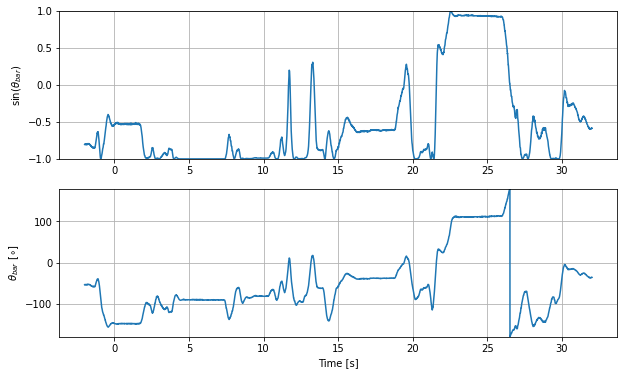

Trial 009: 8.60s (28.7%) in front
Trial 009: Fixation success: True
Trial 009: Maximum fixation duration: 3.84s


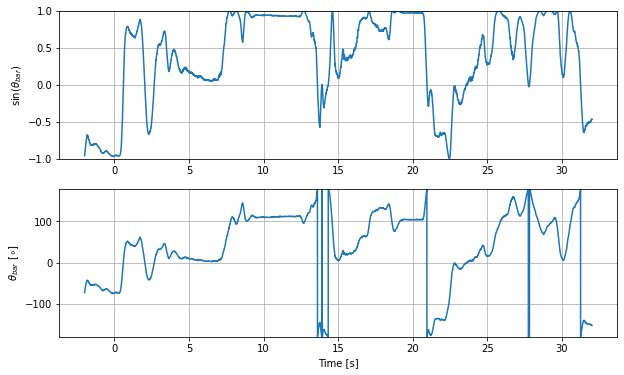

Trial 010: 10.68s (35.6%) in front
Trial 010: Fixation success: True
Trial 010: Maximum fixation duration: 4.86s


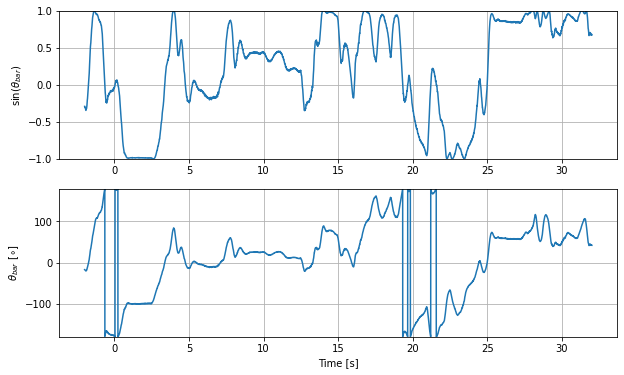

Trial 011: 5.88s (19.6%) in front
Trial 011: Fixation success: True
Trial 011: Maximum fixation duration: 2.87s


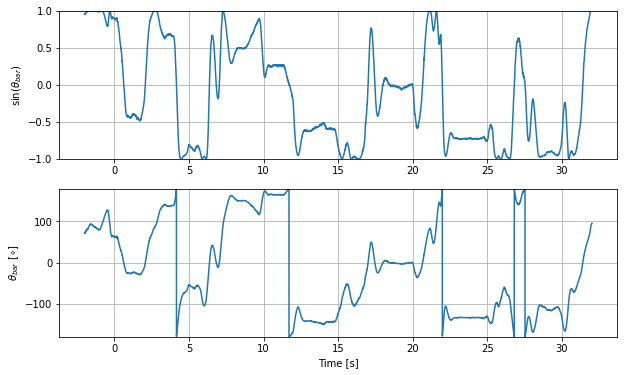

Trial 012: 7.17s (23.9%) in front
Trial 012: Fixation success: False
Trial 012: Maximum fixation duration: 1.48s


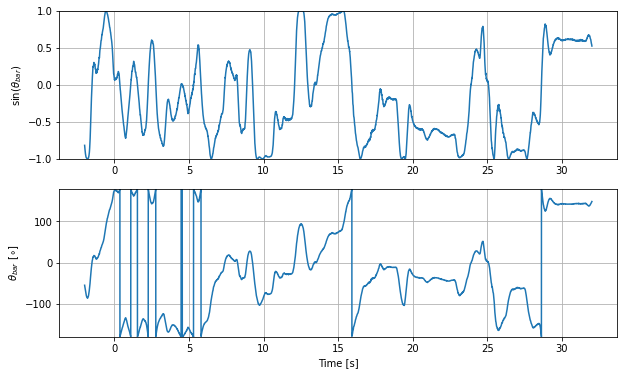

Trial 013: 4.42s (14.7%) in front
Trial 013: Fixation success: False
Trial 013: Maximum fixation duration: 0.87s


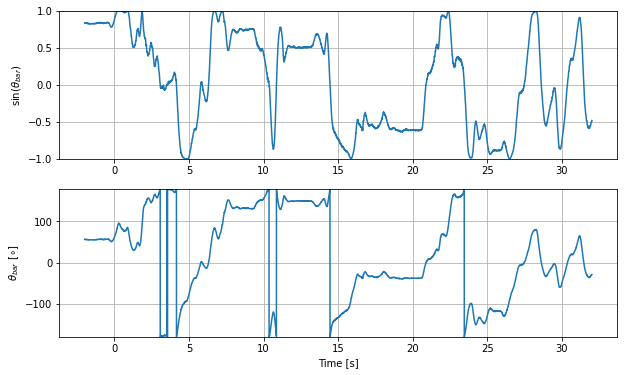

Trial 014: 3.78s (12.6%) in front
Trial 014: Fixation success: False
Trial 014: Maximum fixation duration: 0.57s


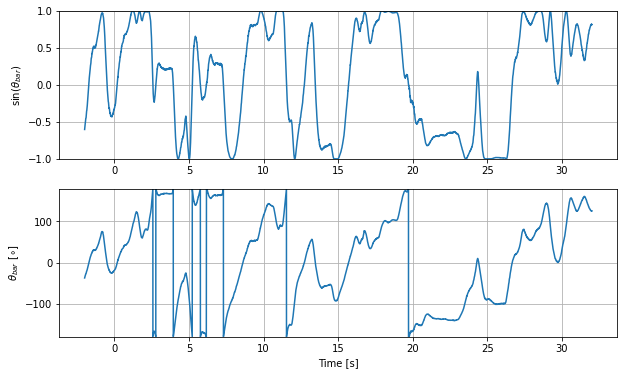

Trial 015: 1.72s (5.7%) in front
Trial 015: Fixation success: False
Trial 015: Maximum fixation duration: 0.79s


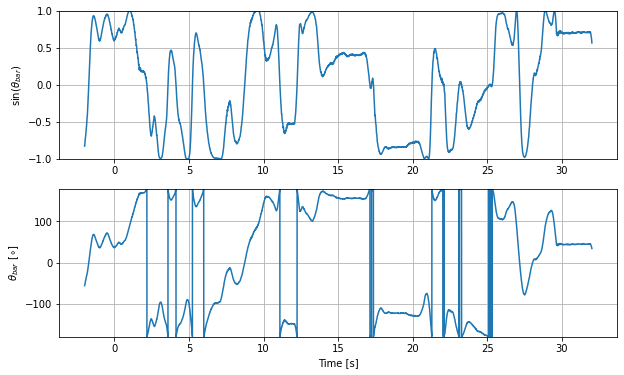

Trial 016: 9.82s (32.7%) in front
Trial 016: Fixation success: True
Trial 016: Maximum fixation duration: 6.58s


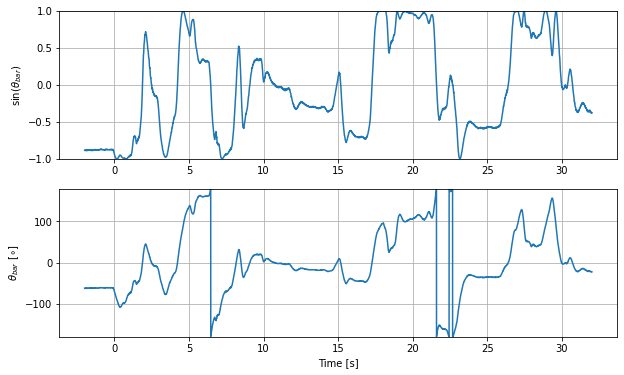

Trial 017: 2.32s (7.7%) in front
Trial 017: Fixation success: False
Trial 017: Maximum fixation duration: 0.53s


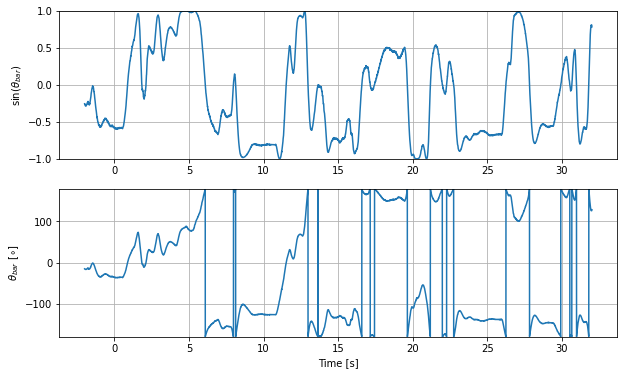

Trial 018: 6.57s (21.9%) in front
Trial 018: Fixation success: False
Trial 018: Maximum fixation duration: 1.94s


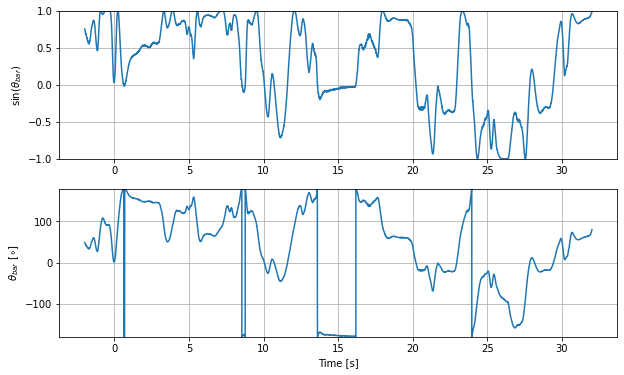

Trial 019: 2.61s (8.7%) in front
Trial 019: Fixation success: False
Trial 019: Maximum fixation duration: 1.24s


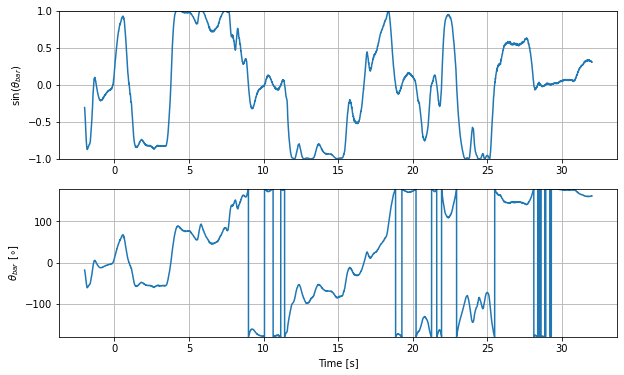

Trial 020: 7.83s (26.1%) in front
Trial 020: Fixation success: False
Trial 020: Maximum fixation duration: 1.32s


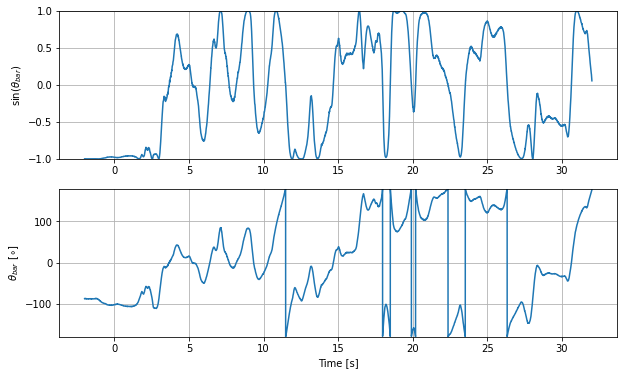

Trial 021: 7.49s (25.0%) in front
Trial 021: Fixation success: False
Trial 021: Maximum fixation duration: 1.82s


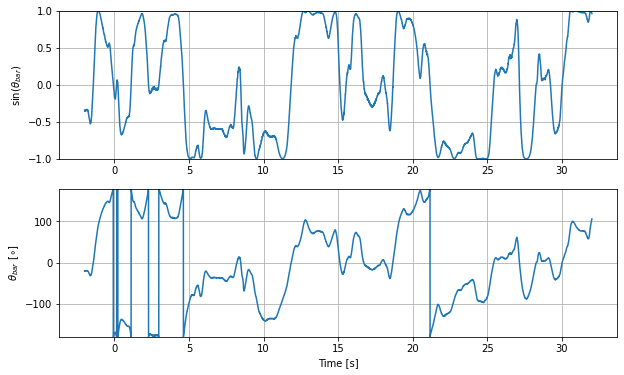

Trial 022: 4.58s (15.3%) in front
Trial 022: Fixation success: False
Trial 022: Maximum fixation duration: 1.49s


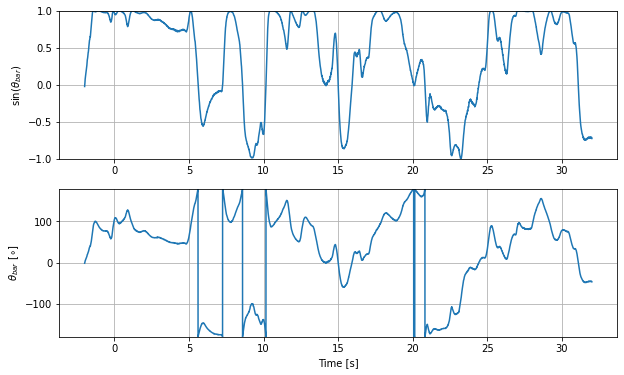

Trial 023: 5.59s (18.6%) in front
Trial 023: Fixation success: False
Trial 023: Maximum fixation duration: 1.63s


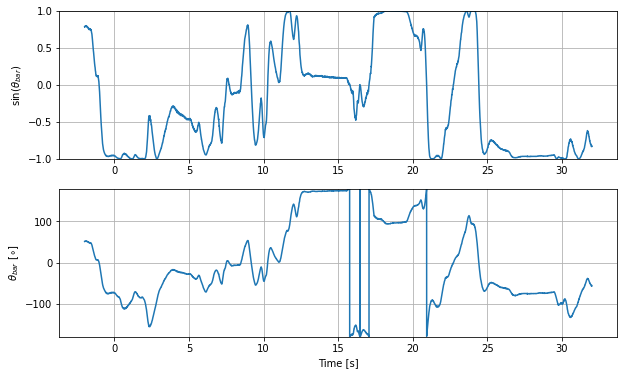

Trial 024: 2.58s (8.6%) in front
Trial 024: Fixation success: False
Trial 024: Maximum fixation duration: 1.14s


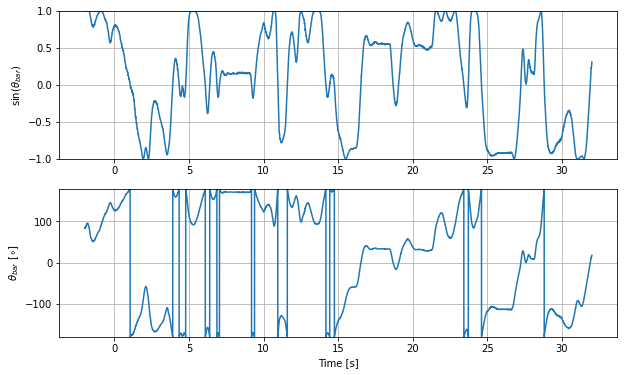

Trial 025: 2.18s (7.3%) in front
Trial 025: Fixation success: False
Trial 025: Maximum fixation duration: 0.42s


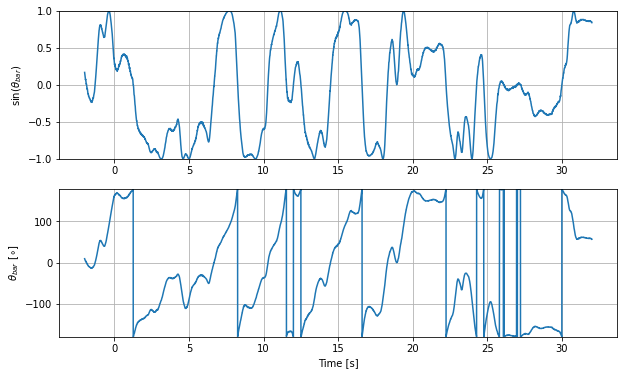

Trial 026: 1.24s (4.1%) in front
Trial 026: Fixation success: False
Trial 026: Maximum fixation duration: 0.70s


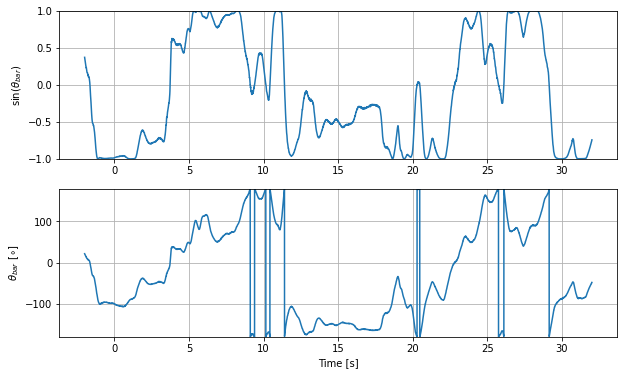

Trial 027: 5.56s (18.5%) in front
Trial 027: Fixation success: True
Trial 027: Maximum fixation duration: 3.45s


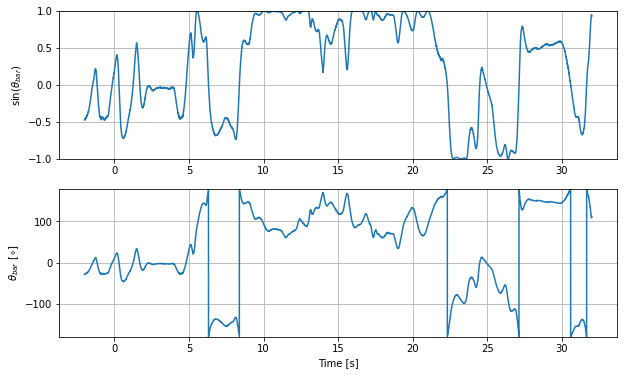

Trial 028: 3.55s (11.8%) in front
Trial 028: Fixation success: False
Trial 028: Maximum fixation duration: 1.68s


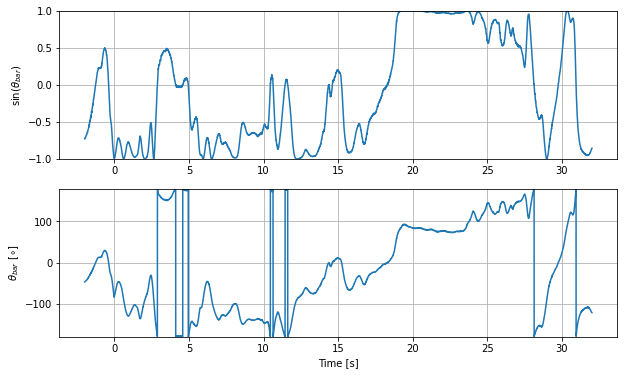

Trial 029: 3.14s (10.5%) in front
Trial 029: Fixation success: False
Trial 029: Maximum fixation duration: 0.93s


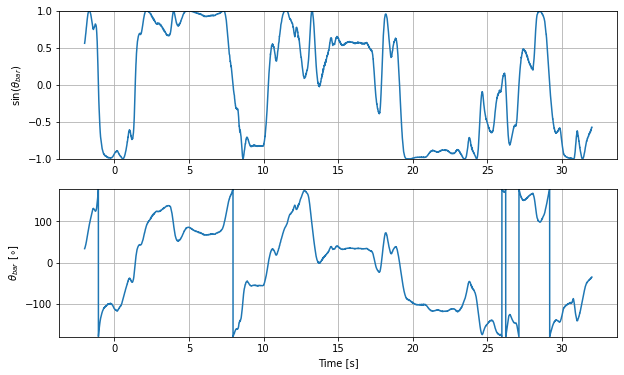

Trial 030: 5.61s (18.7%) in front
Trial 030: Fixation success: False
Trial 030: Maximum fixation duration: 1.09s


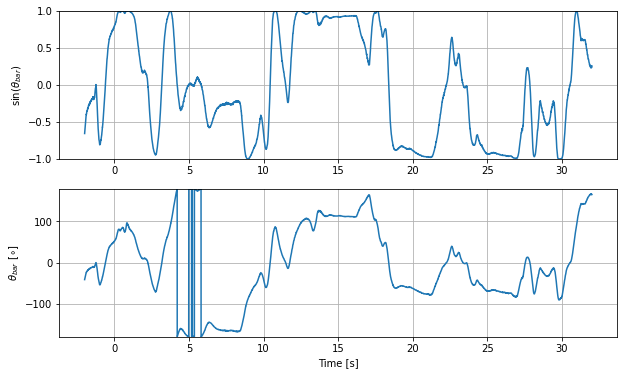

Trial 031: 10.39s (34.6%) in front
Trial 031: Fixation success: True
Trial 031: Maximum fixation duration: 3.18s


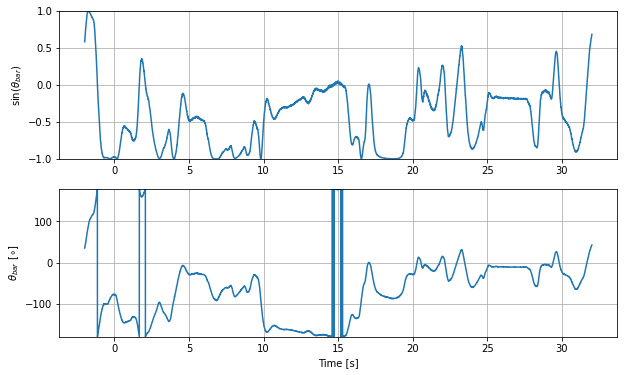

Trial 032: 2.02s (6.7%) in front
Trial 032: Fixation success: False
Trial 032: Maximum fixation duration: 0.56s


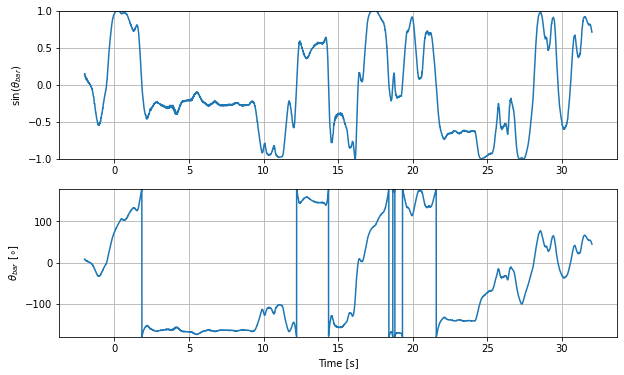

Trial 033: 1.66s (5.5%) in front
Trial 033: Fixation success: False
Trial 033: Maximum fixation duration: 0.73s


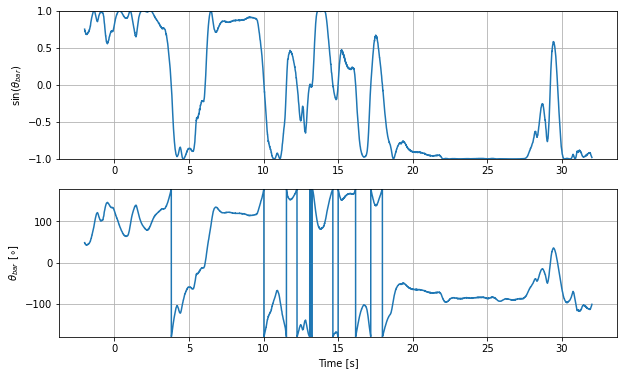

Trial 034: 10.78s (35.9%) in front
Trial 034: Fixation success: True
Trial 034: Maximum fixation duration: 5.67s


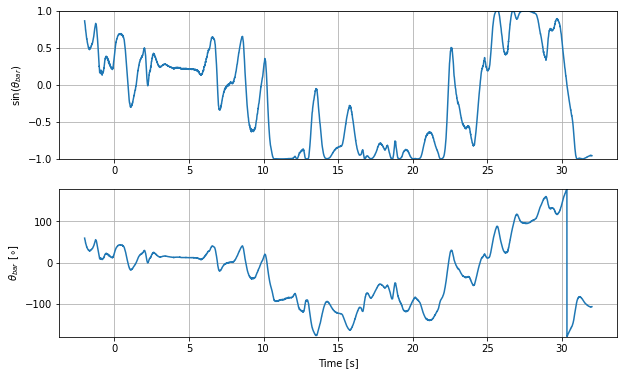

Trial 035: 1.33s (4.4%) in front
Trial 035: Fixation success: False
Trial 035: Maximum fixation duration: 0.75s


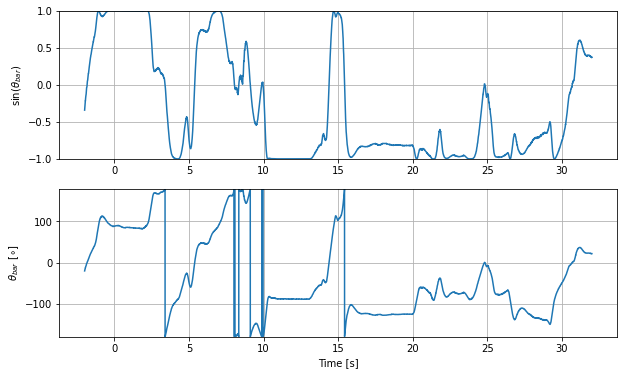

Trial 036: 1.87s (6.2%) in front
Trial 036: Fixation success: False
Trial 036: Maximum fixation duration: 1.06s


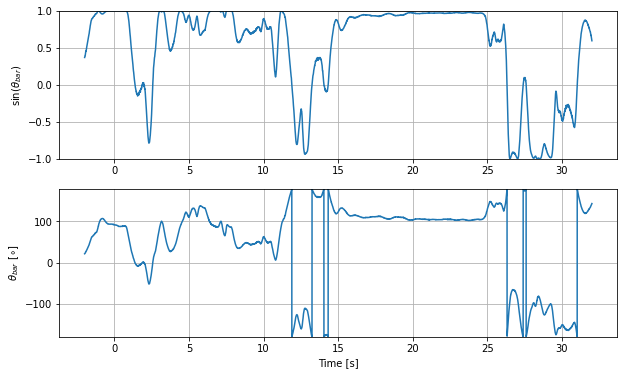

Trial 037: 7.79s (26.0%) in front
Trial 037: Fixation success: True
Trial 037: Maximum fixation duration: 6.06s


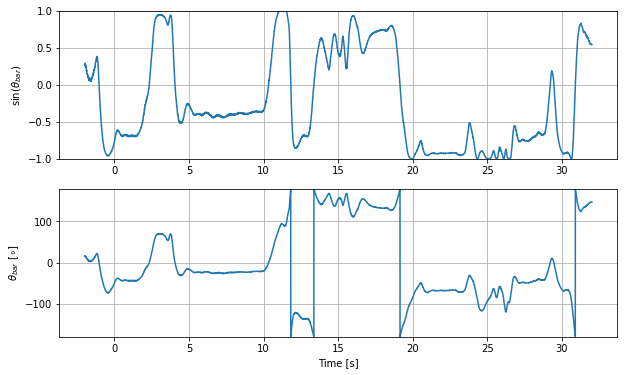

Trial 038: 7.50s (25.0%) in front
Trial 038: Fixation success: False
Trial 038: Maximum fixation duration: 1.38s


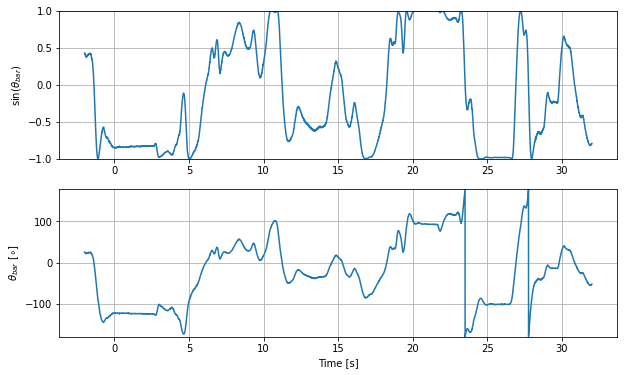

Trial 039: 10.03s (33.4%) in front
Trial 039: Fixation success: True
Trial 039: Maximum fixation duration: 3.07s


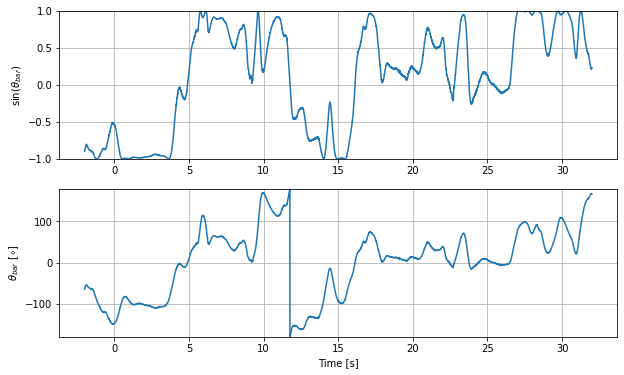

In [221]:

        ### 2. bar's position as a time of function ("theta")



    ## draw histogram of delta from center







hdf_path = "/Users/Shirley/Desktop/data/fix_stationary_data/20220414_122608.h5"

acc_fixation_success_15, acc_fixation_durations_15,acc_max_fixation_duration_15 = analyze_fix_stationary(hdf_path, front_region=[-30,30])


Trial 000: 30.00s (100.0%) in front
Trial 000: Fixation success: True
Trial 000: Maximum fixation duration: 30.00s


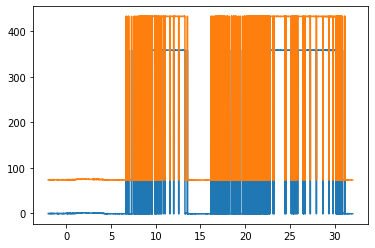

ValueError: Invalid location identifier (invalid location identifier)

In [189]:
acc_fixation_success_30, acc_fixation_durations_30,acc_max_fixation_duration_30 = analyze_fix_stationary(hdf_path, front_region=[-30,30])


In [181]:
value_acc_fixation_success_15 = []
for elem in acc_fixation_success_15:
    value_acc_fixation_success_15.append(int(elem))
#print(value_acc_fixation_success)
sum(value_acc_fixation_success_15)
#plt.plot(value_acc_fixation_success)

6

In [182]:
value_acc_fixation_success_30 = []
for elem in acc_fixation_success_30:
    value_acc_fixation_success_30.append(int(elem))
#print(value_acc_fixation_success)
sum(value_acc_fixation_success_30)
#plt.plot(value_acc_fixation_success)

14

In [163]:
value_acc_fixation_success = []
for elem in acc_fixation_success_30:
    value_acc_fixation_success.append(int(elem))
#print(value_acc_fixation_success)
sum(value_acc_fixation_success)
#plt.plot(value_acc_fixation_success)

22

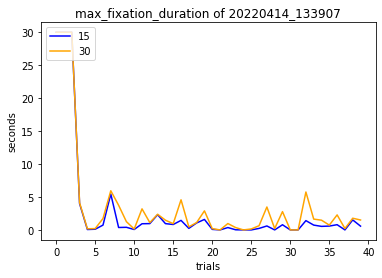

In [183]:
plt.plot(acc_max_fixation_duration_15,color = 'blue',label = '15')
plt.plot(acc_max_fixation_duration_30,color = 'orange',label = '30')
plt.title('max_fixation_duration of 20220414_133907')
plt.xlabel('trials')
plt.ylabel('seconds')
plt.legend(loc = "upper left")

In [38]:
acc_fixation_durations

[array([0.24594244]),
 array([1.07230524, 0.10165585, 0.58370133, 0.1246104 , 0.22954547,
        0.43613638]),
 array([], dtype=float64),
 array([0.11149365, 0.60665661, 0.48860451, 0.1705197 , 0.70503336]),
 array([0.14100691, 1.76750526, 1.02311993, 0.22954614, 0.22626691,
        0.26561767, 0.21642922, 0.14100691]),
 array([0.29840998]),
 array([0.80013039, 0.00655845, 0.00655845, 0.22626638, 0.19675338,
        0.50827955, 0.08853902, 0.20987027, 0.1574027 , 0.11805203,
        0.36727297, 0.33448074, 0.44597432, 0.00655845]),
 array([0.76733995, 0.18691614, 0.12788999]),
 array([0.43941587]),
 array([1.74783097, 0.31480633, 0.10165621, 0.00327923, 0.00327923,
        0.02951309, 0.38039098, 0.0098377 , 0.0098377 , 0.00655847,
        0.71159347, 0.32136479, 0.17707856, 1.17068603, 0.23938398,
        0.49188489, 0.13772777, 0.58698263, 0.51811875]),
 array([0.06558442, 0.1574026 , 0.41974028]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([0.49188374, 1.41662517]

In [42]:
np.shape(acc_fixation_durations)

/Users/Shirley/opt/anaconda3/envs/clandinin/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(40,)

NameError: name 'fixation_success' is not defined